https://www.kaggle.com/competitions/dogs-vs-cats/overview

In [224]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception, ResNet152V2, DenseNet121

In [225]:
IMAGE_WIDTH = 299 # для модели InceptionV3 размер нужен 299х299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 15
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
TRAIN_DIRECTORY = "big-files/train/"
TEST_DIRECTORY = "big-files/test/"

In [226]:
filenames = os.listdir(TRAIN_DIRECTORY)
test_directory = os.listdir(TEST_DIRECTORY)
    # Пути к оригинальным директориям

In [227]:
categories = []
for filename in filenames:
    category = filename.split(".")[0]
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)   

In [228]:
df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

test_df = pd.DataFrame({
    "filename": test_directory
})

<Axes: xlabel='category'>

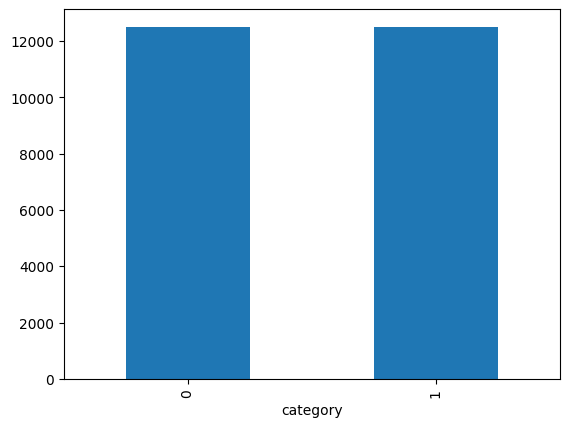

In [229]:
df["category"].value_counts().plot.bar()

In [230]:
# Функция для создания предобученной модели
def create_model(base_model, input_shape, model_name):
    model = base_model(weights="imagenet", include_top=False, input_shape=input_shape)
    model.trainable = False # замораживаем все
    return model

In [231]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
resnet152v2 = create_model(ResNet152V2, input_shape, 'resnet152v2')
xception = create_model(Xception, input_shape, 'xception')
densenet121 = create_model(DenseNet121, input_shape, 'densenet121')

In [232]:
# Создаем входной слой
input_layer = Input(shape=input_shape, name='input_layer')

In [233]:
# Пропускаем входной слой через каждую предобученную модель
resnet152v2_output = resnet152v2(input_layer)
xception_output = xception(input_layer)
densenet121_output = densenet121(input_layer)

In [234]:
# Получаем выходы каждой модели
resnet152v2_output = Flatten()(resnet152v2_output)
xception_output = Flatten()(xception_output)
densenet121_output = Flatten()(densenet121_output)

In [235]:
model_resnet.trainable = False # замораживаем что бы не обучать слои
model_xception.trainable = False # замораживаем что бы не обучать слои
model_densenet.trainable = False # замораживаем что бы не обучать слои

In [236]:
merged_output = Concatenate()([resnet152v2_output, xception_output, densenet121_output])

In [237]:
dense_layer = Dense(256, activation='relu')(merged_output)
dropout_layer = Dropout(0.4)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

In [238]:
final_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [239]:
final_model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["acc"])

In [240]:
df['category'] = df['category'].astype(str)

In [241]:
# Изменяем размер всех изображений в папке до 250x250 пикселей
# for filename in os.listdir(source_folder):
#     img = Image.open(os.path.join(source_folder, filename))
#     img = img.resize((250, 250), Image.ANTIALIAS)  # Изменяем размер до 250x250
#     img.save(os.path.join(target_folder, filename))

In [242]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # для нормализации пикселей изображения в диапазоне [0, 1].
    validation_split = 0.2, # Разделение данных на обучающий и временный наборы (80% на обучение, 20% на валидацию)
    rotation_range=20, # для легкой ротации изображения
    shear_range=0.2, # сдвиг угла
    zoom_range=0.2, # масштабирование
    horizontal_flip=True, # горизонтальный поворот
    vertical_flip=True, # вертикальный поворот
    width_shift_range=0.2, # сдвиг по горизонтали
    height_shift_range=0.2, # сдвиг по вертикали
    brightness_range=(0.8, 1.2), # изменение яркости
    fill_mode='nearest', # для заполнения пикселей за пределами границ
)

test_datagen = ImageDataGenerator(
    rescale=1./255 # проверочнные данные не следует расширять
    ) 

In [243]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=TRAIN_DIRECTORY,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary',
    subset='training'  # Указываем, что это тренировочная часть
)

# Генератор данных для валидации
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=TRAIN_DIRECTORY,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary',
    subset='validation'  # Указываем, что это валидационная часть
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIRECTORY,
    x_col="filename",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


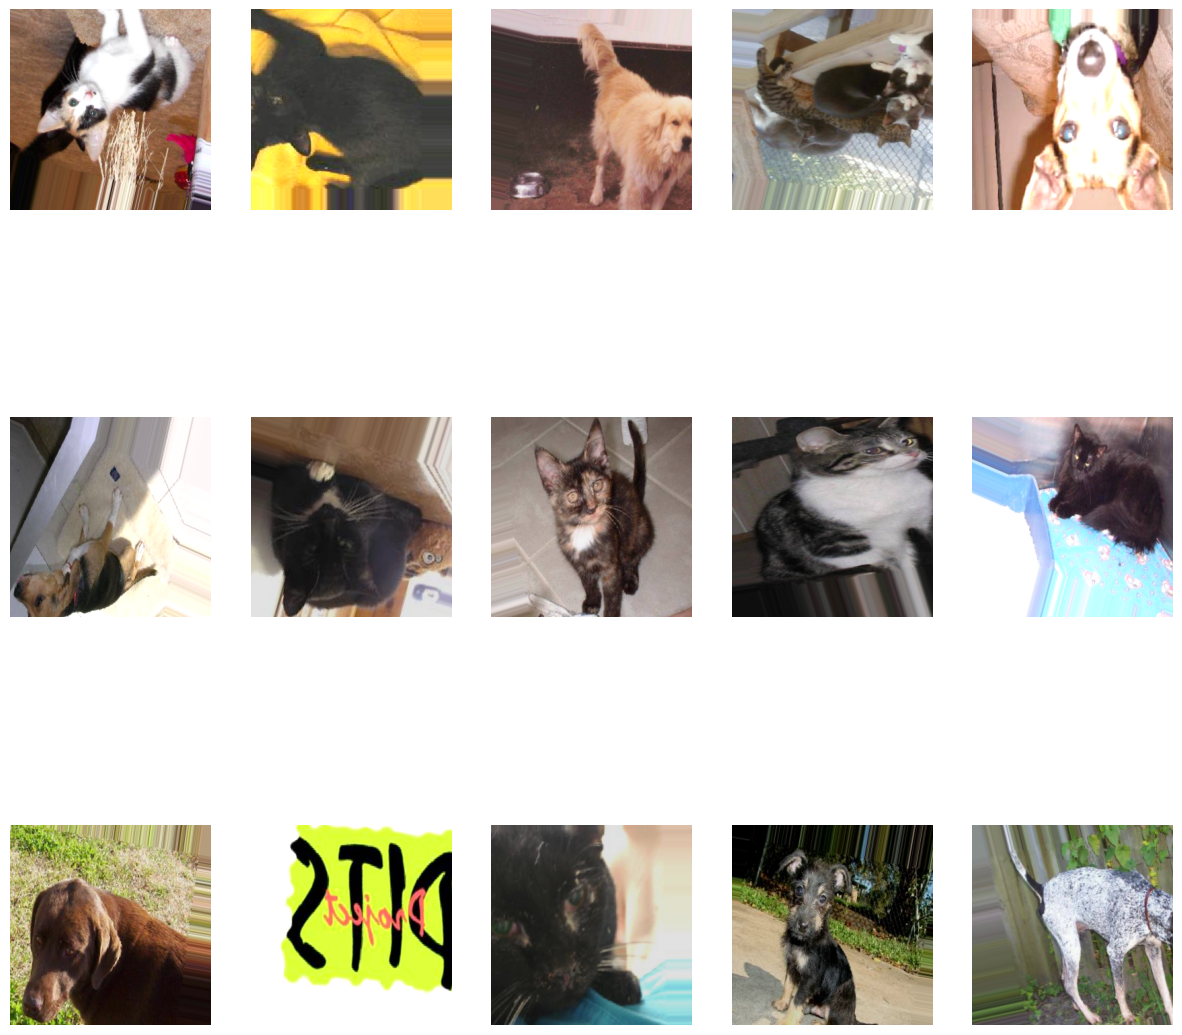

In [244]:
fig, axes = plt.subplots(3, 5, figsize=(15, 15))  
for i in range(3):
    for j in range(5): # 3 строки и 5 столбцов для 15 изображений
        images, labels = next(train_generator)
        axes[i, j].imshow(images[0])
        axes[i, j].axis('off')

plt.show()

In [245]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)


earlystop = EarlyStopping(patience = 5)
    
callbacks = [earlystop, learning_rate_reduction]

In [246]:
final_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152v2         │ (None, 10, 10,    │ 58,331,648 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 10, 10,    │ 20,861,480 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 9, 9,      │  7,037,504 │ input_layer[0][0] │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 204800)    │          0 │ resnet152v2[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 204800)    │          0 │ xception[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 82944)     │          0 │ densenet121[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 492544)    │          0 │ flatten_20[0][0], │
│ (Concatenate)       │                   │            │ flatten_21[0][0], │
│                     │                   │            │ flatten_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │ 126,091,5… │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │        257 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 212,322,409 (809.95 MB)

 Trainable params: 126,091,777 (481.00 MB)

 Non-trainable params: 86,230,632 (328.94 MB)

In [247]:
# Хорошей практикой считается всегда сохранять модели после обучения.
history = final_model.fit(
    train_generator, 
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator) // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // BATCH_SIZE,
)

Epoch 1/15


c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 196s 9s/step - acc: 0.7671 - loss: 15.3916 - val_acc: 0.9453 - val_loss: 4.9517
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - acc: 0.9009 - loss: 9.3394 - val_acc: 0.8516 - val_loss: 17.0888
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - acc: 0.9056 - loss: 6.9107 - val_acc: 0.9453 - val_loss: 5.2334
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - acc: 0.9268 - loss: 4.6943 - val_acc: 0.9062 - val_loss: 5.0864
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step - acc: 0.9258 - loss: 2.8060 - val_acc: 0.9297 - val_loss: 1.3864
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - acc: 0.9193 - loss: 1.6825 - val_acc: 0.9844 - val_loss: 0.1703
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 158s 8s/step - acc: 0.9158 - loss: 0.7564 - val_acc: 0.8984 - val_loss: 1.0130
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - acc: 0.9421 - loss: 0.3042 - val_acc: 0.9375 - val_loss: 0.2452
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - acc: 0.9631 - loss: 

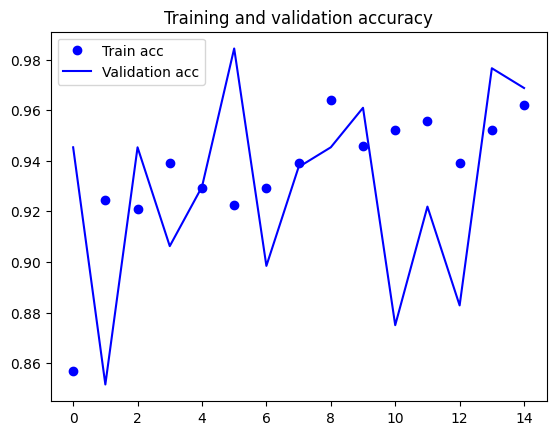

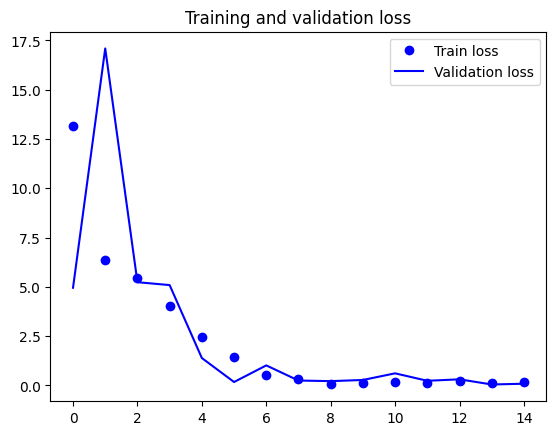

In [248]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(acc, 'bo', label='Train acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


In [250]:
pred = final_model.predict(test_generator)


c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 2614s 7s/step


In [ ]:
# res = np.argmax(pred, axis=1) # Выбираем класс с максимальной вероятностью (метка 1)
threshold = 0.5
res = (pred > threshold).astype(int) # Выбираем класс с максимальной вероятностью (метка 1)

In [ ]:
test_df["category"] = res


<Axes: xlabel='category'>

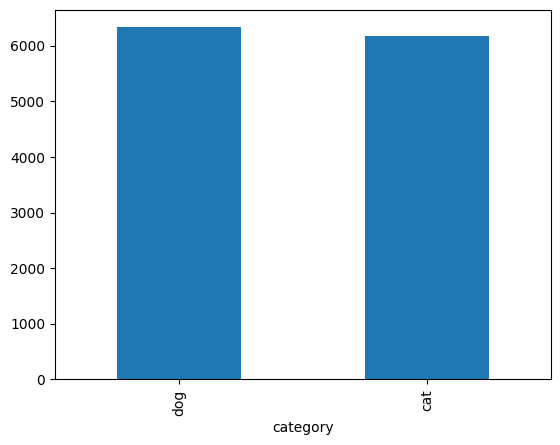

In [ ]:
test_df["category"] = test_df["category"].replace({0: "cat", 1: "dog"})
test_df["category"].value_counts().plot.bar()

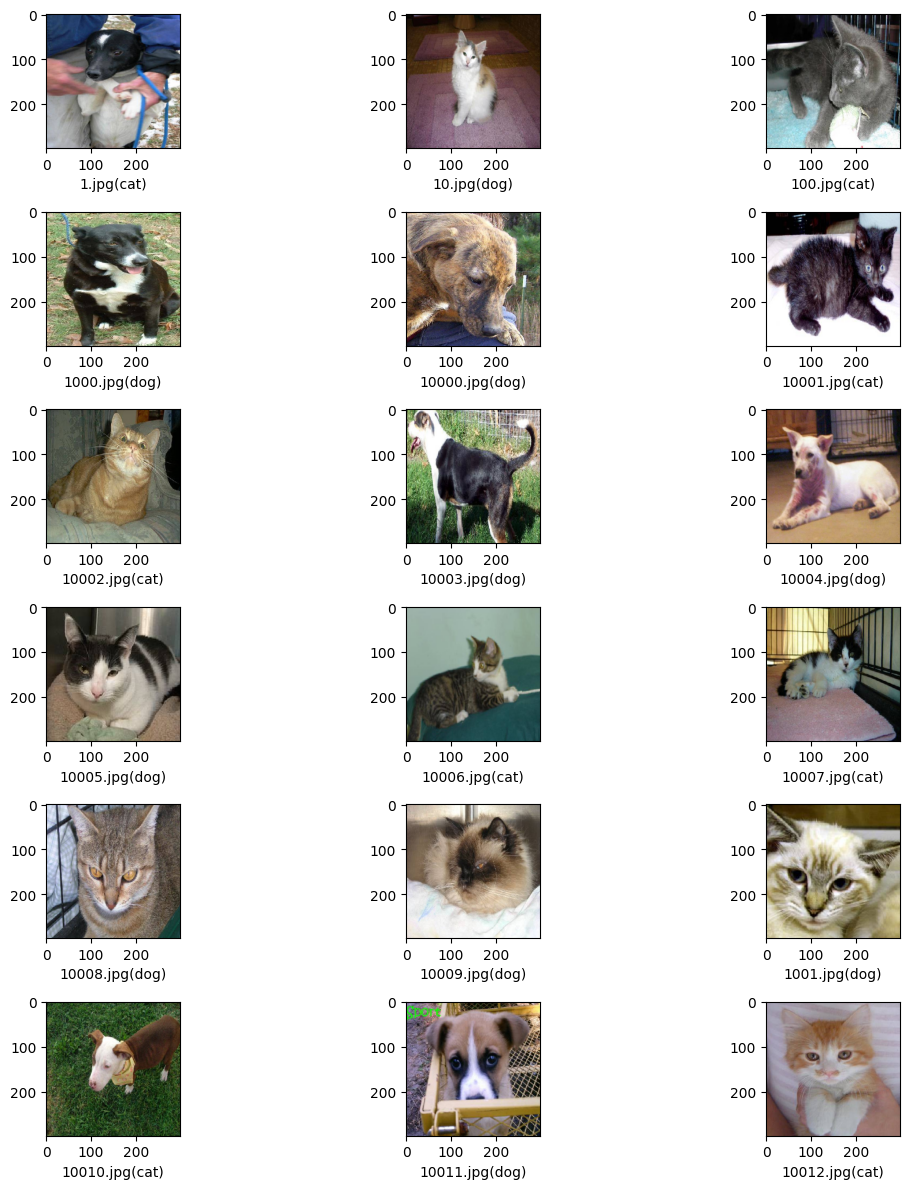

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = image.load_img(TEST_DIRECTORY + filename, target_size = IMAGE_SIZE)
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
res = pd.DataFrame(res)
res = res.rename(columns={0: 'label'})
res.to_csv("file.csv", index=False)

In [ ]:
red = pd.read_csv("file.csv")
red

,label
0,0
1,1
2,0
3,1
4,1
...,...
12495,1
12496,0
12497,0
12498,1
